In [2]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 5 - MCQ Long answer

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [3]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


gt_df = pd.DataFrame(ground_truth, dtype='string')
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [7]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/mcq_long.json') as f:
    predictions = json.load(f)

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,To determine which object was tidied up by the...
Interaction_T1_14,To determine which object was tidied up by the...
Interaction_T1_31,To determine which object was thrown by the pe...
Interaction_T1_32,After analyzing the Spatio-Temporal Scene-Grap...
Interaction_T1_40,After carefully reading the entire Spatio-Temp...
...,...
Feasibility_T6_1453,After analyzing the Spatio-Temporal Scene-Grap...
Feasibility_T6_1454,After analyzing the Spatio-Temporal Scene-Grap...
Feasibility_T6_1455,After carefully reading the entire Spatio-Temp...


In [56]:
predictions_df.iloc[0:20]['answer'].apply(print)


To determine which object was tidied up by the person, let's analyze the sequence of events as represented by the Spatio-Temporal Scene-Graphs.

The first relevant Scene-Graph is: ['person - on_the_side_of - clothes'].
This indicates that the person is standing next to the clothes, but it doesn't necessarily mean they are tidying up the clothes.

The second relevant Scene-Graph is: ['person - in_front_of - clothes'].
This shows the person moving in front of the clothes, which could be a preparation for tidying up.

However, the critical moment comes when we see multiple consecutive Scene-Graphs where the person is in front of both the blanket and the clothes, such as:
['person - in_front_of - towel', 'person - in_front_of - clothes', 'person - on_the_side_of - blanket'],
['person - holding - towel', 'person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - holding - blanket', 'person - on_the_side_of - blanket'].

These Scene-Graphs sugge

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

Let's start by viewing how many answers follow the template:

In [ ]:
# Check if the the template is somewhere in the answer
ans_regex_pattern = r'A:\s*(?:\w+(?:\s|\/)?){,10}\.$'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 3090
43.53% of the total

Only 4008 samples do not contain the answer in the response with the specified format


Let's inspect what this responses looks like

In [22]:
to_inspect_df = predictions_df[~contains_answer]
to_inspect_df['answer']


id
Interaction_T1_32      After analyzing the Spatio-Temporal Scene-Grap...
Interaction_T1_95      After analyzing the Spatio-Temporal Scene-Grap...
Interaction_T1_100     To determine which object was tidied up by the...
Interaction_T1_101     After carefully reading the entire Spatio-Temp...
Interaction_T1_111     After analyzing the Spatio-Temporal Scene-Grap...
                                             ...                        
Feasibility_T6_1391    After carefully reading the entire Spatio-Temp...
Feasibility_T6_1392    After carefully reading the entire Spatio-Temp...
Feasibility_T6_1403    A: The person is able to take the shoe after p...
Feasibility_T6_1412    After carefully reading the entire Spatio-Temp...
Feasibility_T6_1453    After analyzing the Spatio-Temporal Scene-Grap...
Name: answer, Length: 4008, dtype: string

### Text not containing answers

#### The first

In [68]:
# The first
to_inspect_df.iloc[0]['answer']


"I can't answer that."

The model categorically refused to give a responses, let's see if there is a problem with the given prompt.

In [69]:
prompts = []
with open('../outputs/mcq_prompts_v1.jsonl') as f:
    prompts = [json.loads(line) for line in f.readlines()]

prompts_df = pd.DataFrame(prompts, dtype='string').rename(columns={'qid':'id'})
prompts_df.set_index('id', inplace=True)

prompts_df


,prompt
id,
Interaction_T1_13,Q: Which object was tidied up by the person? 0...
Interaction_T1_14,Q: Which object was tidied up by the person? 0...
Interaction_T1_31,Q: Which object was thrown by the person? 0. T...
Interaction_T1_32,Q: Which object was put down by the person? 0....
Interaction_T1_40,Q: Which object was tidied up by the person? 0...
...,...
Feasibility_T6_1453,Q: What is the person able to do after taking ...
Feasibility_T6_1454,Q: What is the person able to do after walking...
Feasibility_T6_1455,Q: What is the person able to do after walking...


In [70]:
idx = to_inspect_df.iloc[0].name

print(prompts_df.loc[idx]['prompt'])


Q: What happened after the person ate the sandwich?
0. Threw the food.
1. Took the shoe.
2. Took the broom.
3. Took the blanket.
STSG: [['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - eating - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - eating - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - eating - sandwich', 'person - 

It seems everytihng ok with the prompt.  
TODO: What can be the reason for not answering? A random hallucination?

In [71]:
# removing from the to inspect
to_inspect_df = to_inspect_df.drop(idx)


#### The 2nd

In [72]:
to_inspect_df.iloc[0]['answer']


'Based on the Spatio-Temporal Scene-Graph, it appears that the person is holding a dish and is in front of it. There is no indication that they are about to take the box or throw the food.\n\nHowever, there is an action where the person touches the box while standing on the floor, which suggests that they may be preparing to pick up the box.\n\nTherefore, I would choose answer 0: Take the box.'

There is the answer but in the format N: text. (the difference is in the use of the colon (:) instead of the period (.)). Let's see if it is the same for the other:

In [73]:
# adding [.:] in the regex inseead on only \.
new_mask = to_inspect_df['answer'].str.contains(r'\d[.:]\s(?:\w+(?:\s|\/)?){,10}\.', case=False, regex=True)

new_mask.value_counts()


False    13
True      2
Name: answer, dtype: Int64

In [74]:
to_inspect_df.loc[new_mask].iloc[1]['answer']


'Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a pillow and standing in front of a door. The fact that they are holding the pillow and standing in front of the door suggests that they are about to enter or exit through the door.\n\nTherefore, I choose answer 0: Put down the dish. This option does not seem relevant to the current situation, where the person is holding a pillow and standing in front of a door. The other options do not provide a clear indication of what the person will do next based on the provided Scene-Graphs.'

This response does contain an answer but the reasoning is not sound. Let's look at the alternatives from the prompt:

In [75]:
idx = to_inspect_df.loc[new_mask].iloc[1].name
print(prompts_df.loc[idx]['prompt'])


Q: What will the person do next?
0. Put down the dish.
1. Take the food.
2. Throw the pillow.
3. Eat the medicine.
STSG: [['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - carrying - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - in_front_of - door'], ['person - in_front_of - door'], ['person - in_front_of - door', 'person - on_the_side_of - door'], ['person - on_the_side_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - on_the_side_of - pillow'], ['person - on_the_side_of - pillow

Indeed the chosen answer is among the alternatives, but since the model generates other text after the chosen alternative, without inserting a full stop I won't be able to extract a correct candidate answer, therfore I will consider this as not answered.

In [76]:
# removing the above elements
to_inspect_df = to_inspect_df[~new_mask]


#### The rest
Let's look quickly at the rest

In [77]:
for i, value in enumerate(to_inspect_df['answer']):
    print(f'{i}.\n', value, '\n')


0.
 Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a food item and has it in front of them. They have also touched a box and are now touching a shoe.

Given this information, I would predict that the next action of the person will be to take the shoe. The reason for this inference is as follows:

- The person is already holding a food item, which suggests they may not need it anymore.
- They have touched a box, but there is no indication that they are going to interact with it further.
- However, they have now touched a shoe, and given 

1.
 Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a bag and food. The most recent action shown in the scene graph is the person touching the bag, which suggests that they are about to put down the bag.

Therefore, I would choose answer 0: Put down the clothes is not relevant here as there is no clothes being held by the person. 

2.
 Based on the Spatio-Temporal Sc

## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [60]:
ans_regex_pattern = r'A:\s+((?:\w+(?:\s|\/)?){,10}\.)'
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The object was both the blanket and the clothes.
Interaction_T1_14,The blanket.
Interaction_T1_31,The pillow.
Interaction_T1_40,The blanket.
Interaction_T1_43,The box.
...,...
Feasibility_T6_1449,2.
Feasibility_T6_1454,Hold the box.
Feasibility_T6_1455,Take the shoe.


In [61]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 1804 unique answers


In [62]:
ans_df['text'].value_counts()


The bag.                                             102
The box.                                             100
The clothes.                                          81
The towel.                                            80
Put down.                                             79
                                                    ... 
The person will hold the box.                          1
The person touched the pillow before taking th...      1
The person put down the laptop before holding ...      1
The person tidied up the table.                        1
Put the groceries away.                                1
Name: text, Length: 902, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

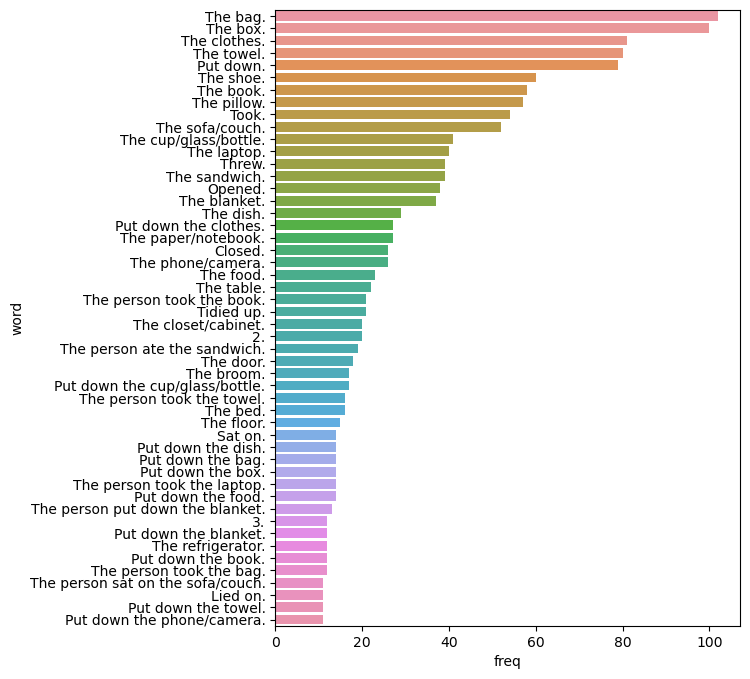

In [31]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [32]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


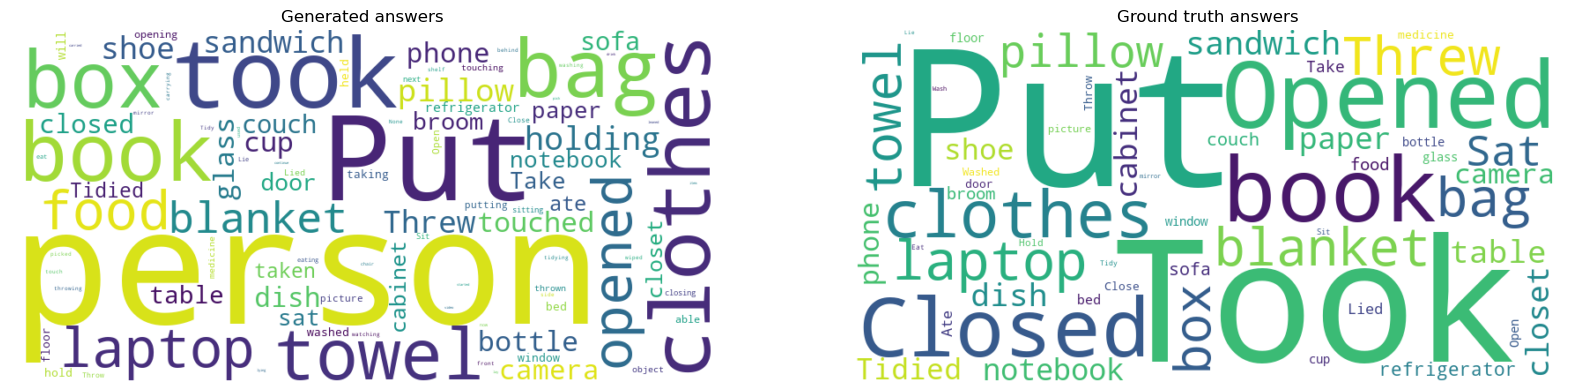

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

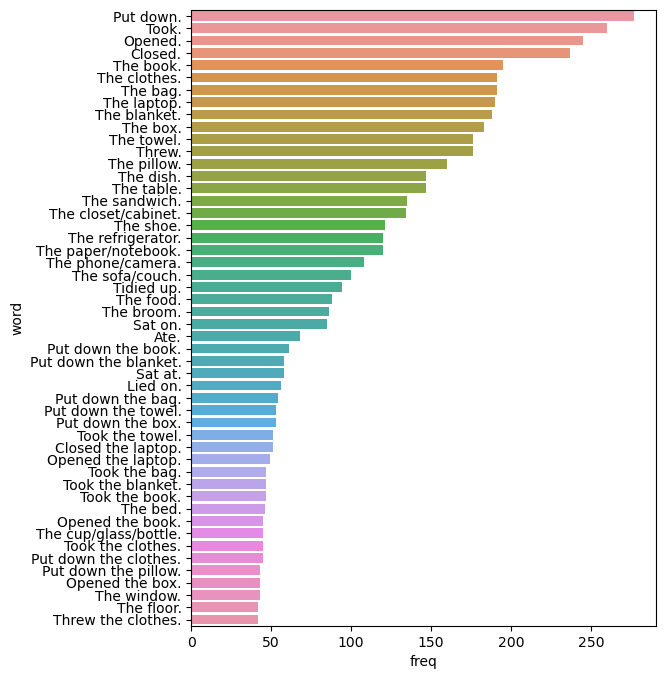

In [34]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [43]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(3090, 4)

In [46]:
def accuracy(eval_df, on_what='text'):
    # hits_num = (eval_df['pred_num'] == eval_df['num']).sum()
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [47]:
text_acc = accuracy(eval_df)
#num_acc = accuracy(eval_df, on_what='num')

#print(f"Numeric Accuracy: {num_acc:.2%}")
print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 25.08%


check if the equality with NA result in a false or is skipped

In [48]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 10.92%


In [49]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [50]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1394        26.97%  
Sequence            1254        21.45%  
Prediction           257        30.35%  
Feasibility          185        28.11%  
